# Setup

Clone repo, install dependencies, `%cd` into `./yolov5` folder and check GPU.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# 2. Test
Test a model on COCO val or test-dev dataset to determine trained accuracy. Models are auto-downloaded from [Google Drive](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J). To show results by class use the `--verbose` flag. Note that `pycocotools` metrics may be 1-2% better than the equivalent repo metrics, as is visible below, due to slight differences in mAP computation.

### 2.1 val2017
Download COCO val 2017 dataset, 1GB, 5000 images, and test model accuracy.

In [ ]:
# Download COCO val2017
gdrive_download('1Y6Kou6kEB0ZEMCCpJSKStCor4KAReE43','coco2017val.zip')  # val2017 dataset
!mv ./coco ../  # move folder alongside /yolov5

In [53]:
# Run YOLOv5x on COCO val2017
!python test.py --weights runs/exp1/weights/best.pt --data kkctbn.yaml --img 416

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/kkctbn.yaml', device='', img_size=416, iou_thres=0.65, merge=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['runs/exp1/weights/best.pt'])
Fusing layers... 
Scanning labels ../kkctbn/labels.cache (402 found, 0 missing, 0 empty, 0 duplicate, for 402 images): 402it [00:00, 10086.38it/s]
               Class      Images     Targets           P           R      mAP@.5
                 all         402    1.39e+03       0.673       0.935       0.929       0.487
Speed: 1.8/1.8/3.6 ms inference/NMS/total per 416x416 image at batch-size 32


# 3. Train

In [27]:
!mkdir ../kkctbn
!cp -r /kaggle/input/kkctbn ../kkctbn

mkdir: cannot create directory ‘../kkctbn’: File exists


In [19]:
!mkdir ../kkctbn/images
!mkdir ../kkctbn/labels
!mv ../kkctbn/dataset/*.txt ../kkctbn/labels
!mv ../kkctbn/dataset/*.jpg ../kkctbn/images

In [30]:
!cp /kaggle/input/kkctbn/kkctbn.yaml ./data
!cp /kaggle/input/kkctbn/yolov5s.yaml ./models/yolov5s2.yml

In [33]:
!ls ./models

__init__.py  experimental.py  yolo.py	    yolov5s.yaml
__pycache__  export.py	      yolov5l.yaml  yolov5s2.yml
common.py    hub	      yolov5m.yaml  yolov5x.yaml


In [31]:
!ls data

coco.yaml     hyp.finetune.yaml  kkctbn.yaml  voc.yaml
coco128.yaml  hyp.scratch.yaml	 scripts


In [ ]:
# Start tensorboard (optional)
%load_ext tensorboard
%tensorboard --logdir runs

In [42]:
# Train YOLOv5s on coco128 for 3 epochs
!python train.py --img 416 --batch 16 --epochs 50 --data kkctbn.yaml --cfg yolov5s2.yml --weights yolov5s.pt --nosave --cache

2020-09-29 07:46:29.814952: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Overriding model.yaml nc=80 with nc=2

Scanning labels ../kkctbn/labels.cache (402 found, 0 missing, 0 empty, 0 duplicate, for 402 images): 402it [00:00, 10746.67it/s]
Caching images (0.2GB): 100%|████████████████| 402/402 [00:01<00:00, 298.95it/s]
Scanning labels ../kkctbn/labels.cache (402 found, 0 missing, 0 empty, 0 duplicate, for 402 images): 402it [00:00, 2701.75it/s]
Caching images (0.2GB): 100%|████████████████| 402/402 [00:02<00:00, 183.98it/s]

Analyzing anchors... anchors/target = 5.08, Best Possible Recall (BPR) = 1.0000
      0/49    0.818G    0.1241   0.05478   0.02647    0.2053         5       416
               Class      Images     Targets           P           R      mAP@.5
                 all         402    1.39e+03           0           0     0.00715      0.0022
      1/49     1.49G    0.1066   0.06273   0.01857    0.1879

# 4. Visualize

View `runs/exp0/train*.jpg` images to see training images, labels and augmentation effects. A **Mosaic Dataloader** is used for training (shown below), a new concept developed by Ultralytics and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

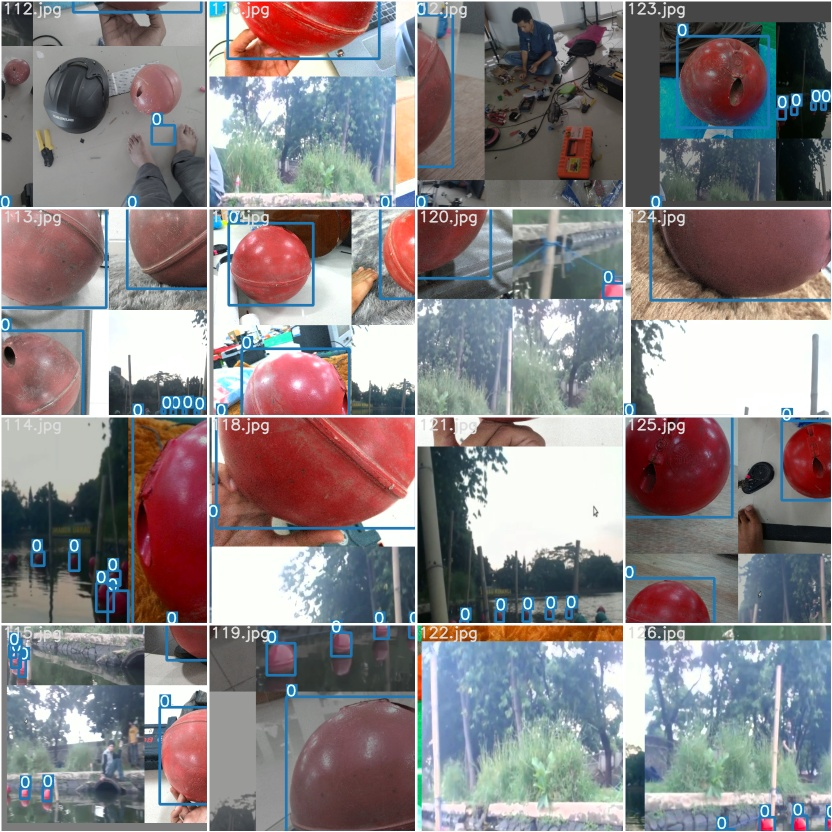

In [43]:
Image(filename='runs/exp0/train_batch1.jpg', width=900)  # view augmented training mosaics

View `test_batch0_gt.jpg` to see test batch 0 *ground truth* labels.

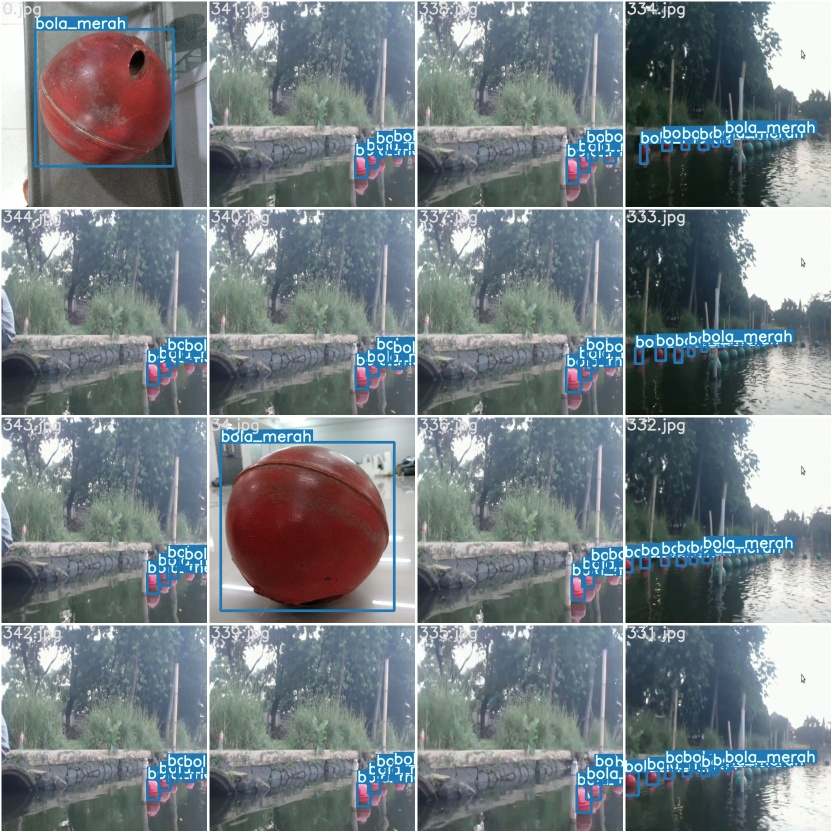

In [44]:
Image(filename='runs/exp0/test_batch0_gt.jpg', width=900)  # view test image labels

View `test_batch0_pred.jpg` to see test batch 0 *predictions*.

In [48]:
!ls runs/exp1

events.out.tfevents.1601365591.6416aa4de09b.1060.0  test_batch0_gt.jpg
hyp.yaml					    test_batch0_pred.jpg
labels.png					    train_batch0.jpg
labels_correlogram.png				    train_batch1.jpg
opt.yaml					    train_batch2.jpg
results.png					    weights
results.txt


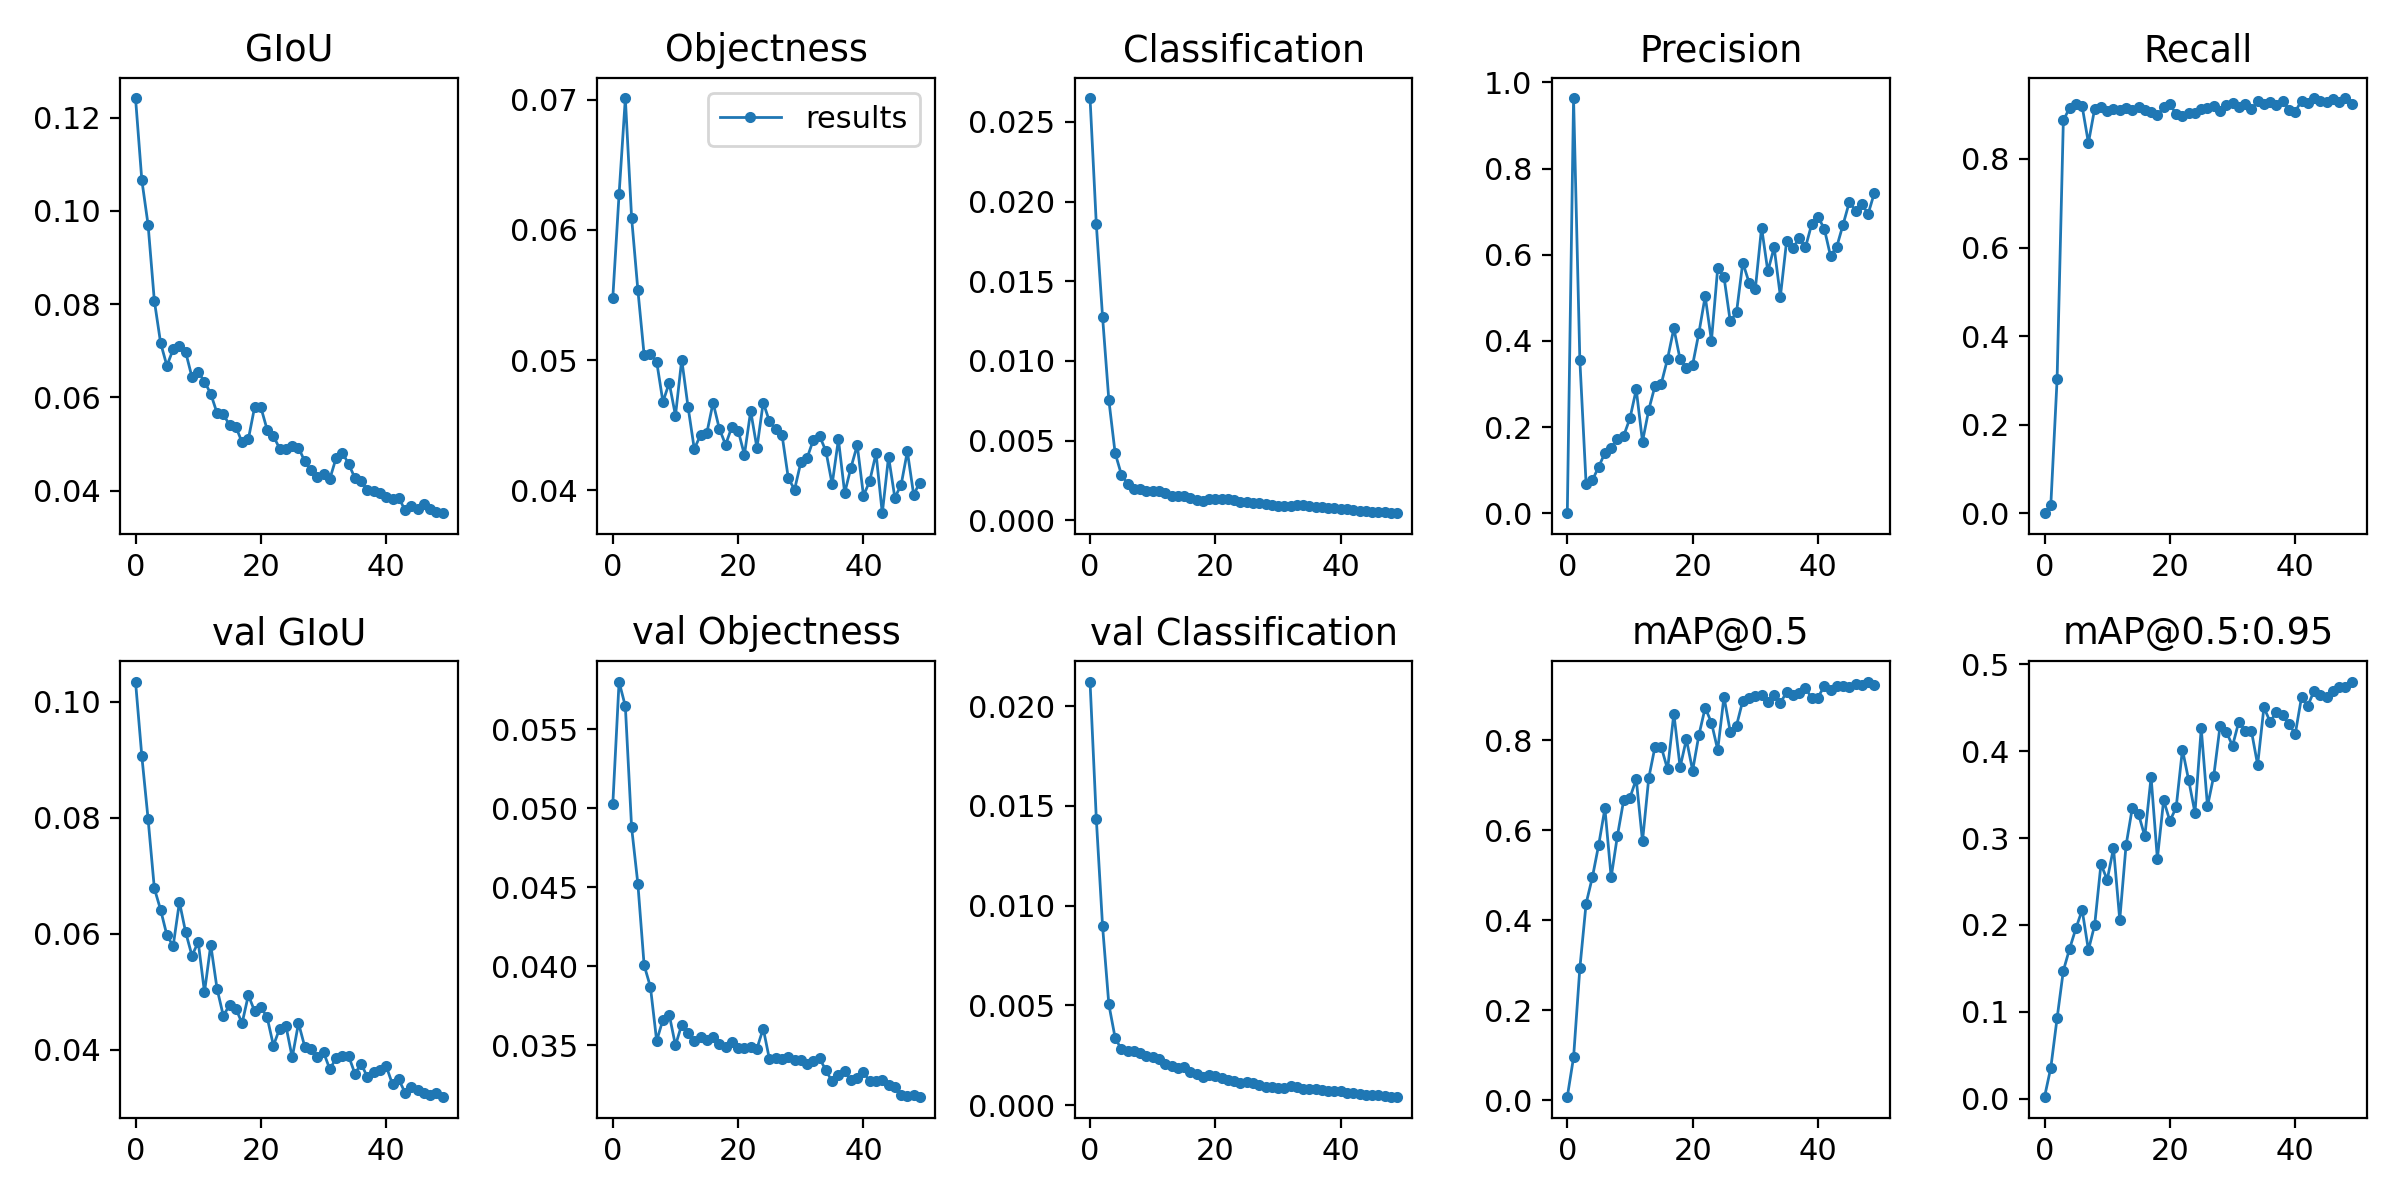

In [52]:
Image(filename='runs/exp1/results.png', width=900)

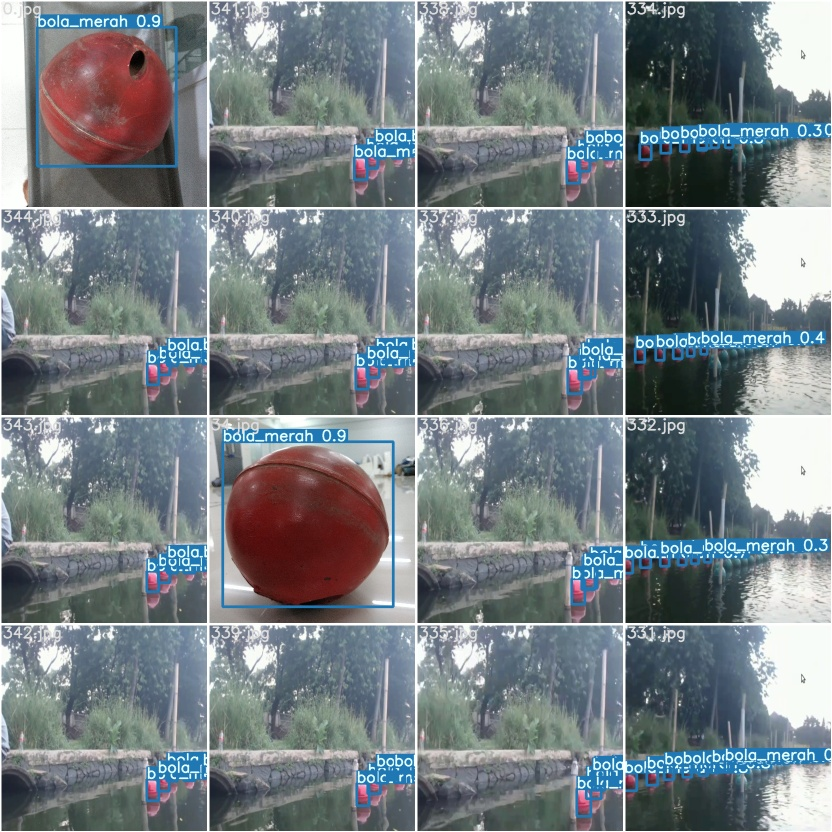

In [51]:
Image(filename='runs/exp1/test_batch0_pred.jpg', width=900)  # view test image predictions

Training losses and performance metrics are saved to Tensorboard and also to a `runs/exp0/results.txt` logfile. `results.txt` is plotted as `results.png` after training completes. Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`. Here we show YOLOv5s trained on coco128 to 300 epochs, starting from scratch (blue), and from pretrained `yolov5s.pt` (orange).